<a href="https://colab.research.google.com/github/Manas-Todi/LSTM-Stock-Price-Prediction/blob/main/LSTM_stock_prices_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM Time Series - Stock Price Prediction

## Part 1 - Exploratory Data Analysis (EDA)

In this notebook, we'll explore the raw dataset containing Google's daily historical stock prices. Our objective is to define a specific period that will be used for modeling and prediction with LSTM.

**INPUT:** Complete historical stock price data for Google (Alphabet Inc.) obtained from the original source.  
**OUTPUT:** Filtered historical data for the chosen timeframe, saved as an intermediate file for subsequent analysis.

---

### 1. Setup and Initialization


In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import joblib
import matplotlib.dates as mdates
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

### 2. Load Dataset

We'll begin by loading and exploring the historical daily stock price data for Google (Alphabet Inc.), which has been sourced from Yahoo Finance.

The dataset covers the period from **2004-08-19** to **April 2024**.  
Our primary goal in loading the entire dataset is to examine it and select a specific timeframe that will be used for further analysis and modeling.


In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
data = pd.read_csv('/content/drive/MyDrive/google_stock_price_full.csv')

In [38]:
data.shape

(4940, 7)

In [39]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,2.490664,2.591785,2.390042,2.499133,2.499133,897427216
1,2004-08-20,2.515820,2.716817,2.503118,2.697639,2.697639,458857488
2,2004-08-23,2.758411,2.826406,2.716070,2.724787,2.724787,366857939
3,2004-08-24,2.770615,2.779581,2.579581,2.611960,2.611960,306396159
4,2004-08-25,2.614201,2.689918,2.587302,2.640104,2.640104,184645512


In [40]:
data.dtypes

,0
Date,object
Open,float64
High,float64
Low,float64
Close,float64
Adj Close,float64
Volume,int64


### 3. Initial Data Cleaning

We observe that the **Date** column is currently stored as a string.  
We need to convert it into a proper datetime format to enable time-based analysis and filtering.


In [41]:
# converting date column to a valid form
data["Date"] = pd.to_datetime(data["Date"])
data.dtypes

,0
Date,datetime64[ns]
Open,float64
High,float64
Low,float64
Close,float64
Adj Close,float64
Volume,int64


### 4. Exploring the dataset

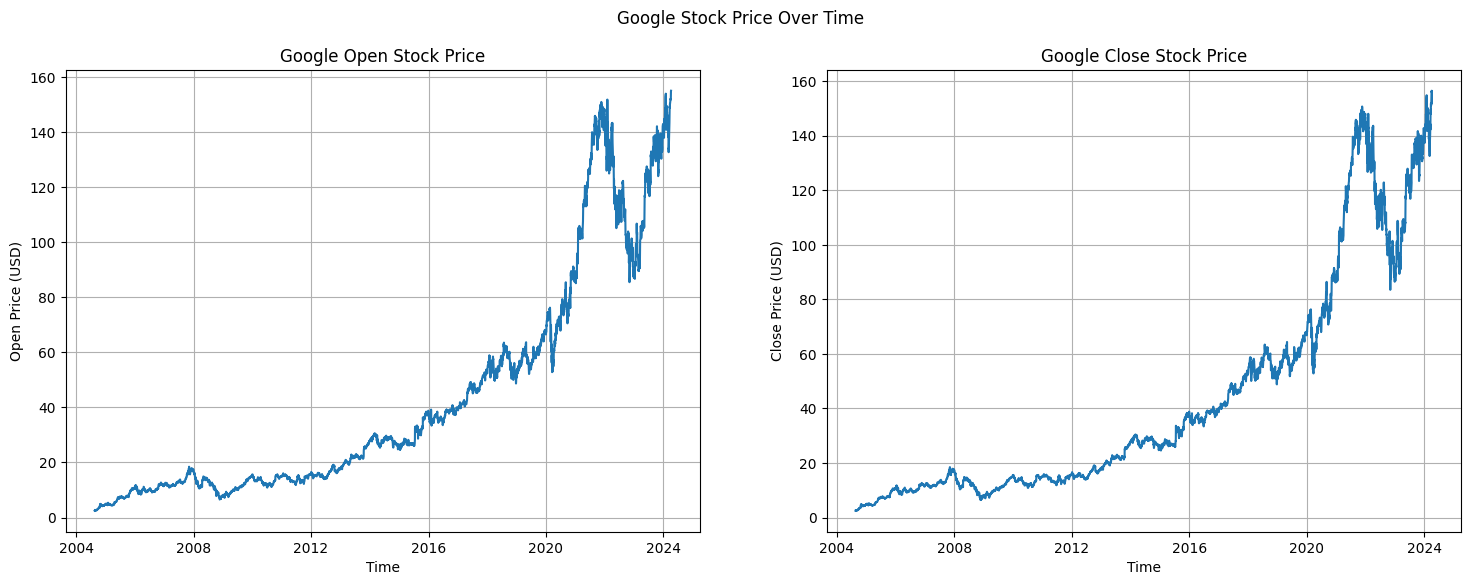

In [42]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
plt.plot(data["Date"], data["Open"])
plt.xlabel("Time")
plt.ylabel("Open Price (USD)")
plt.title("Google Open Stock Price")
plt.grid()

plt.subplot(1,2,2)
plt.plot(data["Date"], data["Close"])
plt.xlabel("Time")
plt.ylabel("Close Price (USD)")
plt.title("Google Close Stock Price")
plt.grid()

plt.suptitle("Google Stock Price Over Time")
plt.show()

The previous visualizations reveal inconsistencies in the stock's behavior over time, with a notably distinct trend emerging in the most recent five years.

As a result, older historical data may be less relevant for prediction, as it likely reflects outdated market conditions that no longer influence the stock's current movement.

Therefore, we will focus our analysis on the **most recent five years** of data, as this period is expected to provide more relevant and accurate insights for forecasting future trends.

In [43]:
# Select stock price records for the last five years, starting from 2019
data_5years = data[data["Date"].dt.year >= 2019]

# Checking filtered data shape
data_5years.shape

(1323, 7)

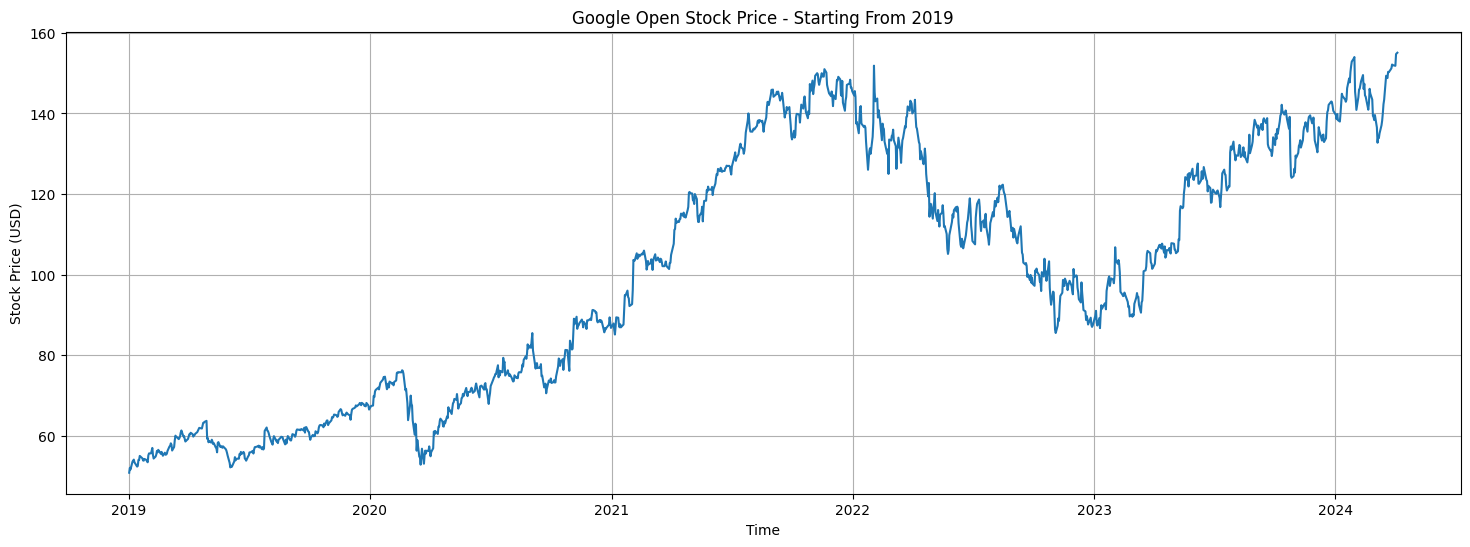

In [44]:
# Plot Open stock price performance in the last five years
plt.figure(figsize=(18,6))
plt.plot(data_5years["Date"], data_5years["Open"])
plt.xlabel("Time")
plt.ylabel("Stock Price (USD)")
plt.title("Google Open Stock Price - Starting From 2019")
plt.grid()

The selected period seems to be more relevant for analysis, as it's more likely to drive the stock performance with the impact of other external factors.

### 5. FILTERED DATASET

In [45]:
data_5years.to_csv("google_stock_price_recent.csv", index=None)
pd.set_option("display.width", 120)
data = pd.read_csv('/content/google_stock_price_recent.csv')
data.shape

(1323, 7)

### 6. DATA PREPROCESSING

In [46]:
# Convert date column to a valid format
data["Date"] = pd.to_datetime(data["Date"])

data.dtypes

,0
Date,datetime64[ns]
Open,float64
High,float64
Low,float64
Close,float64
Adj Close,float64
Volume,int64


Our goal is to perform a **multivariate prediction** that considers the potential influence of multiple independent variables—such as the Open price, Close price, and Volume—on future stock price behavior.

For this analysis, we will include **all available features**:

- Opening price
- Highest price
- Lowest price
- Closing price
- Adjusted closing price
- Trading volume

These variables will serve as inputs to the model, which will be trained to **forecast the future opening price**.

In [47]:
# Define selected features and target attribute
features = ["Open", "High", "Low",	"Close", "Adj Close", "Volume"]
target = "Open"

### 7. Creating Train, Validation, and Test Datasets

To effectively evaluate our model’s performance, we will split the recent stock price data into three distinct sets: **training**, **validation**, and **testing**.

The planned split is as follows:

- **Training dataset:** Data from the start of 2019 through June 2023.
- **Validation dataset:** Stock prices from July 2023 to the end of 2023.
- **Testing dataset:** Stock prices for the first two months of 2024.

This partitioning will allow us to train the model, fine-tune hyperparameters, and finally assess its predictive capability on unseen data.
**bold text**

In [48]:
# Define start and end time for each period
train_end_date = pd.to_datetime("2023-06-30")
validate_start_date = pd.to_datetime("2023-07-01")
validate_end_date = pd.to_datetime("2023-12-31")
test_start_date = pd.to_datetime("2024-01-01")
test_end_date = pd.to_datetime("2024-02-29")

# Split dataset into training, validation, and testing
data_train = data[data["Date"] <= train_end_date][features]
data_train_dates = data[data["Date"] <= train_end_date]["Date"]
data_validate = data[(data["Date"] >= validate_start_date) & (data["Date"] <= validate_end_date)][features]
data_validate_dates = data[(data["Date"] >= validate_start_date) & (data["Date"] <= validate_end_date)]["Date"]
data_test = data[(data["Date"] >= test_start_date) & (data["Date"] <= test_end_date)][features]
data_test_dates = data[(data["Date"] >= test_start_date) & (data["Date"] <= test_end_date)]["Date"]
# Display the shape of each dataset
print(f"Training Set: {data_train.shape}")
print(f"Validation Set: {data_validate.shape}")
print(f"Testing Set: {data_test.shape}")

Training Set: (1132, 6)
Validation Set: (126, 6)
Testing Set: (41, 6)


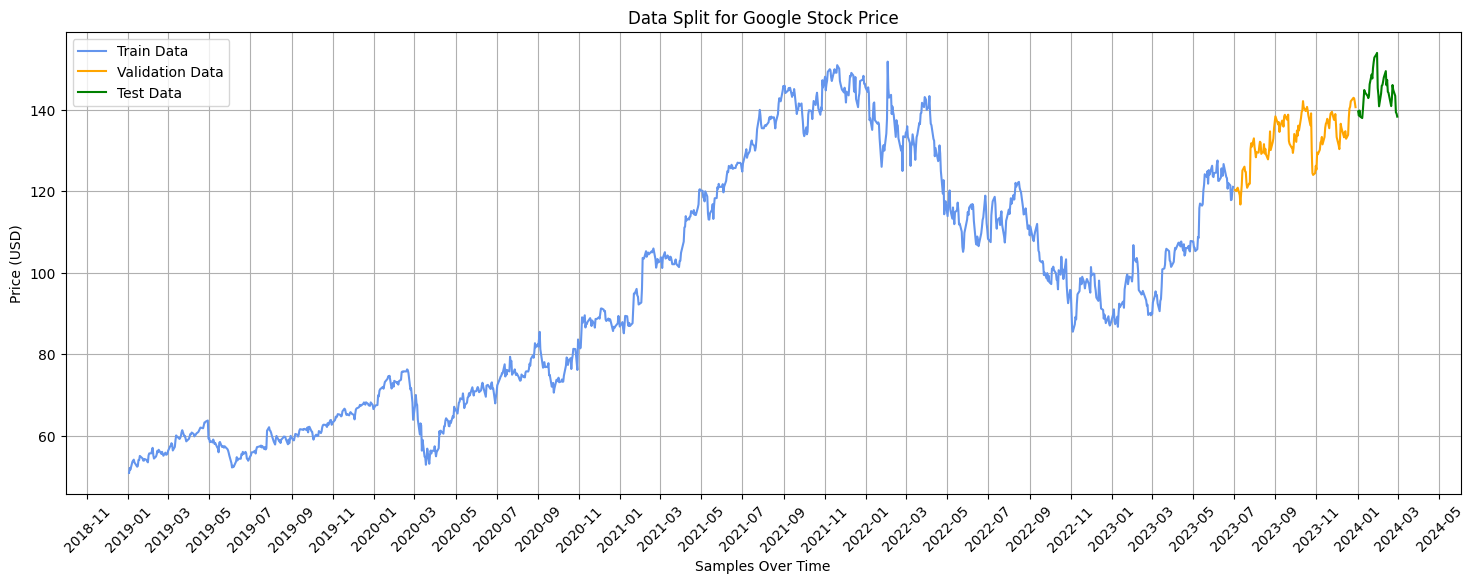

In [49]:
# Plot stock prices for each data split
plt.figure(figsize=(18,6))
plt.plot(data_train_dates, data_train["Open"], color="cornflowerblue")
plt.plot(data_validate_dates, data_validate["Open"], color="orange")
plt.plot(data_test_dates, data_test["Open"], color="green")
plt.legend(["Train Data", "Validation Data", "Test Data"])
plt.title("Data Split for Google Stock Price")
plt.xlabel("Samples Over Time")
plt.ylabel("Price (USD)")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.xticks(rotation=45)
plt.grid()

### 8. Data Scaling

In [50]:
data[features].describe()

,Open,High,Low,Close,Adj Close,Volume
count,1323.000000,1323.000000,1323.000000,1323.000000,1323.000000,1.323000e+03
mean,100.882880,102.042442,99.853834,100.974635,100.974635,2.882756e+07
std,31.078299,31.360869,30.780336,31.059813,31.059813,1.268332e+07
min,50.828499,52.374500,50.676800,50.803001,50.803001,6.936000e+06
25%,71.211247,71.905250,70.356251,70.992001,70.992001,2.076335e+07
50%,102.825996,103.927498,101.500000,102.751503,102.751503,2.575600e+07
75%,130.778503,132.021675,129.389999,130.440002,130.440002,3.287305e+07
max,155.080002,157.000000,154.132004,156.500000,156.500000,1.241400e+08


From the analysis, we can see that all **price-related features** exhibit similar distributions, reflecting daily price fluctuations.  
However, the **trading volume** shows a distinctly different distribution.

To ensure all input features are on a **consistent scale**, we will normalize them to a **[0, 1] range**. Since the data does not display any significant outliers, this scaling approach is appropriate.

To **prevent data leakage**, we will fit the scaler **only** on the training dataset. The trained scaler will then be used to transform the trai


In [51]:
# Initialize scaler with range [0,1]
sc = MinMaxScaler(feature_range=(0,1))

# Fit and transform scaler to training set
data_train_scaled = sc.fit_transform(data_train)

# Transform validating and testing datasets
data_validate_scaled = sc.transform(data_validate)
data_test_scaled = sc.transform(data_test)

### 9. STORING PROCESSED DATASETS
The training, validation, and testing datasets have been processed and are prepared for training the LSTM model in the next phase.

Prior to saving these datasets, it is necessary to reassemble the dates corresponding to each dataset. This will facilitate later evaluation of the model's performance.


In [52]:
# Combine dates with each corresponding dataset
data_train_scaled_final = pd.DataFrame(data_train_scaled, columns=features, index=None)
data_train_scaled_final["Date"] = data_train_dates.values

data_validate_scaled_final = pd.DataFrame(data_validate_scaled, columns=features, index=None)
data_validate_scaled_final["Date"] = data_validate_dates.values

data_test_scaled_final = pd.DataFrame(data_test_scaled, columns=features, index=None)
data_test_scaled_final["Date"] = data_test_dates.values
# Store datasets
data_train_scaled_final.to_csv("google_stock_price_processed_train.csv", index=None)
data_validate_scaled_final.to_csv("google_stock_price_processed_validate.csv", index=None)
data_test_scaled_final.to_csv("google_stock_price_processed_test", index=None)

### 10. Model Training

With the exploratory data analysis complete and the data scaled, we will now import the prepared dataset files, reformat them for LSTM modeling, and train our LSTM model.

**INPUT:** Scaled datasets for the training, validation, and testing periods, processed in the previous step.  
**OUTPUT:** A trained LSTM model along with an evaluation of its performance on validation and test data.


In [53]:
# Load data files
data_train_df = pd.read_csv('/content/google_stock_price_processed_train.csv')
data_validate_df = pd.read_csv('/content/google_stock_price_processed_validate.csv')
data_test_df = pd.read_csv('/content/google_stock_price_processed_test')
# Check loaded datasets shape
print(f"Training Dataset Shape: {data_train_df.shape}")
print(f"Validation Dataset Shape: {data_validate_df.shape}")
print(f"Testing Dataset Shape: {data_test_df.shape}")

Training Dataset Shape: (1132, 7)
Validation Dataset Shape: (126, 7)
Testing Dataset Shape: (41, 7)


In [54]:
# Convert Date column to a valid Datetime format
data_train_df["Date"] = pd.to_datetime(data_train_df["Date"])
data_validate_df["Date"] = pd.to_datetime(data_validate_df["Date"])
data_test_df["Date"] = pd.to_datetime(data_test_df["Date"])
# Extract dates from each dataset
data_train_dates = data_train_df["Date"]
data_validate_dates = data_validate_df["Date"]
data_test_dates = data_test_df["Date"]

In [55]:
# Extract features
features = ["Open", "High", "Low",	"Close", "Adj Close", "Volume"]
data_train_scaled = data_train_df[features].values
data_validate_scaled = data_validate_df[features].values
data_test_scaled = data_test_df[features].values

### 11. Constructing the Data Structure

Since we are tackling a **multivariate time series** problem, we need to reshape our input data to fit the requirements of an LSTM model.

This involves defining a **sliding window (sequence size)** that specifies how many past observations will be used to predict the next value.

In this setup, we will use a sequence of previous **financial days** (including all available variables) to predict the **opening price** of the following day.


In [56]:
# Define a method to construct the input data X and Y
def construct_lstm_data(data, sequence_size, target_attr_idx):

    data_X = []
    data_y = []

    # Iterate over the dataset
    for i in range(sequence_size, len(data)):
        data_X.append(data[i-sequence_size:i,0:data.shape[1]])
        data_y.append(data[i,target_attr_idx])

    return np.array(data_X), np.array(data_y)

In [57]:
# Define the sequence size
sequence_size = 60

# Construct training data
X_train, y_train = construct_lstm_data(data_train_scaled, sequence_size, 0)

When preparing input data for validation and testing, we need to ensure that each prediction has access to the required **sequence of prior observations**.

For example, predicting the **first value** in the validation period requires including the latest stock prices from the **end of the training period** as context.  
This is essential so the LSTM model receives the **expected input sequence** for accurate forecasting.

The same principle applies to the **testing phase**, where (depending on the sequence size) we may need to combine samples from both the **validation and testing** sets.

To handle this correctly, we will **concatenate the entire scaled dataset** and then extract the appropriate overlapping segments before constructing the input sequences for each split.


In [58]:
# Combine scaled datasets all together
data_all_scaled = np.concatenate([data_train_scaled, data_validate_scaled, data_test_scaled], axis=0)

# Calculate data size
train_size = len(data_train_scaled)
validate_size = len(data_validate_scaled)
test_size = len(data_test_scaled)

# Construct validation dataset
X_validate, y_validate = construct_lstm_data(data_all_scaled[train_size-sequence_size:train_size+validate_size,:], sequence_size, 0)

# Construct testing dataset
X_test, y_test = construct_lstm_data(data_all_scaled[-(test_size+sequence_size):,:], sequence_size, 0)

### 12. TRAINING LSTM MODEL
Building LSTM Model

In [59]:
# Initializing the model
regressor = Sequential()

In [60]:
# Add a total of 4 LSTM layer and 4 dropout regularization layer
regressor.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(LSTM(units = 100, return_sequences = True))
regressor.add(Dropout(rate = 0.2))
regressor.add(LSTM(units = 100, return_sequences = True))
regressor.add(Dropout(rate = 0.2))
regressor.add(LSTM(units = 100, return_sequences = True))
regressor.add(Dropout(rate = 0.2))
regressor.add(LSTM(units = 100))
regressor.add(Dropout(rate = 0.2))

# Add last dense layer/output layer
regressor.add(Dense(units = 1))

# Compiling the model
regressor.compile(optimizer = "adam", loss="mean_squared_error")

Train the model

In [61]:
# Create a checkpoint to monitor the validation loss and save the model with the best performance.
model_location = "/content/" # Added a forward slash at the end
model_name = "google_stock_price_lstm.model.keras"
best_model_checkpoint_callback = ModelCheckpoint(
    model_location + model_name,
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=0)

In [62]:
# Check if GPU is available
gpu_available = tf.config.list_physical_devices('GPU')

if gpu_available:
    print("GPU is available")
else:
    print("No GPU available, training will run on CPU.")

GPU is available


In [63]:
# Training the model
history = regressor.fit(
    x = X_train,
    y = y_train,
    validation_data=(X_validate, y_validate),
    epochs=200,
    batch_size = 64,
    callbacks = [best_model_checkpoint_callback])

Epoch 1/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 0.1106 - val_loss: 0.0490
Epoch 2/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0150 - val_loss: 0.0024
Epoch 3/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0070 - val_loss: 0.0032
Epoch 4/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0055 - val_loss: 0.0027
Epoch 5/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0041 - val_loss: 0.0032
Epoch 6/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0042 - val_loss: 0.0025
Epoch 7/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0042 - val_loss: 0.0025
Epoch 8/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0047 - val_loss: 0.0024
Epoch 9/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0044 - val_loss: 0.0026
Epoch 10/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0044 - val_loss: 0.0024
Epoch 11/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0043 - val_loss: 0.0028
Epoch 12/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step

### 12. Performance Evaluation

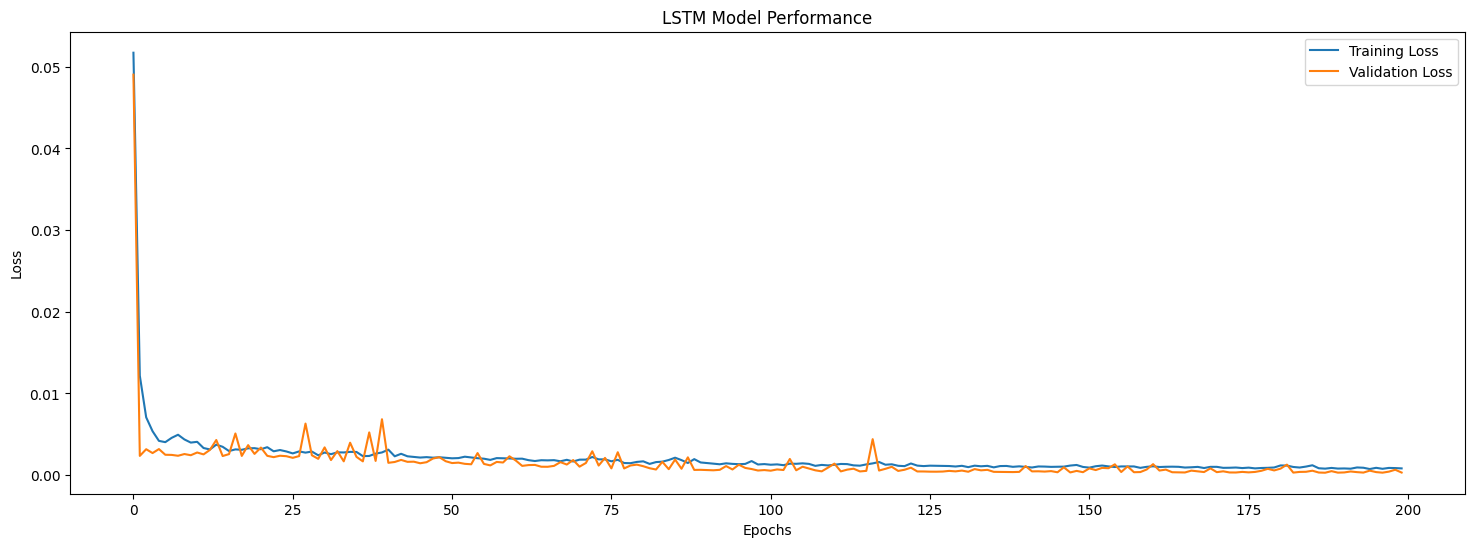

In [64]:
# Visualizing model performance during training
plt.figure(figsize=(18, 6))

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")

plt.title("LSTM Model Performance")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

The loss curves reveal the following insights:

- **Training loss** steadily decreases over epochs, indicating that the model is successfully learning from the training data.
- **Validation loss** also shows an initial decline, suggesting the model is improving its generalization to unseen data.
- **Minor fluctuations** in the validation loss are observed, which is expected due to the inherent volatility and complexity of stock price movements.
- There are **no signs of overfitting**, as both training and validation losses follow a similar downward trend throughout the training process.
- Interestingly, the **validation loss remains slightly lower** than the training loss for most epochs, which can be typical when the training set is more complex or noisy.

### 13. Model Inference

With the LSTM model trained and validated, we are now ready to use it for **forecasting future price trends**.

As outlined earlier, we will apply the model to predict **Google stock prices during the testing period**.  
To thoroughly evaluate its performance, we will generate predictions for the entire testing timeframe and **compare them with the actual observed prices**.


In [65]:
#load best model
best_model = load_model('/content/google_stock_price_lstm.model.keras')

In [66]:
# Predict stock price for all data splits
y_train_predict = best_model.predict(X_train)
y_validate_predict = best_model.predict(X_validate)
y_test_predict = best_model.predict(X_test)

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


### Inverse Scaling

Since the model was trained on **scaled data**, it’s essential to convert the predictions back to their **original price range** for meaningful interpretation.

To do this, we will **reuse the same scaler** that was initially fitted to the training data. This ensures consistent mapping back to the real distribution of stock prices.

The original scaler was fitted on **six features** (all variables), but during inverse transformation, we only need to recover the **"Open" price**.  
To avoid errors with the `inverse_transform` API, we'll construct a placeholder array with the required shape, populate its first column with our predictions, and then **extract only the transformed "Open" price** after applying the inverse scaling.

In [69]:
# Save the scaler object
joblib.dump(sc, '/content/google_stock_price_scaler.gz')

['/content/google_stock_price_scaler.gz']

In [70]:
sc = joblib.load('/content/google_stock_price_scaler.gz')

In [71]:
# Restore actual distribution for predicted prices
y_train_inv = sc.inverse_transform(np.concatenate((y_train.reshape(-1,1), np.ones((len(y_train.reshape(-1,1)), 5))), axis=1))[:,0]
y_validate_inv = sc.inverse_transform(np.concatenate((y_validate.reshape(-1,1), np.ones((len(y_validate.reshape(-1,1)), 5))), axis=1))[:,0]
y_test_inv = sc.inverse_transform(np.concatenate((y_test.reshape(-1,1), np.ones((len(y_test.reshape(-1,1)), 5))), axis=1))[:,0]

y_train_predict_inv = sc.inverse_transform(np.concatenate((y_train_predict, np.ones((len(y_train_predict), 5))), axis=1))[:,0]
y_validate_predict_inv = sc.inverse_transform(np.concatenate((y_validate_predict, np.ones((len(y_validate_predict), 5))), axis=1))[:,0]
y_test_predict_inv = sc.inverse_transform(np.concatenate((y_test_predict, np.ones((len(y_test_predict), 5))), axis=1))[:,0]

## Display Predictions

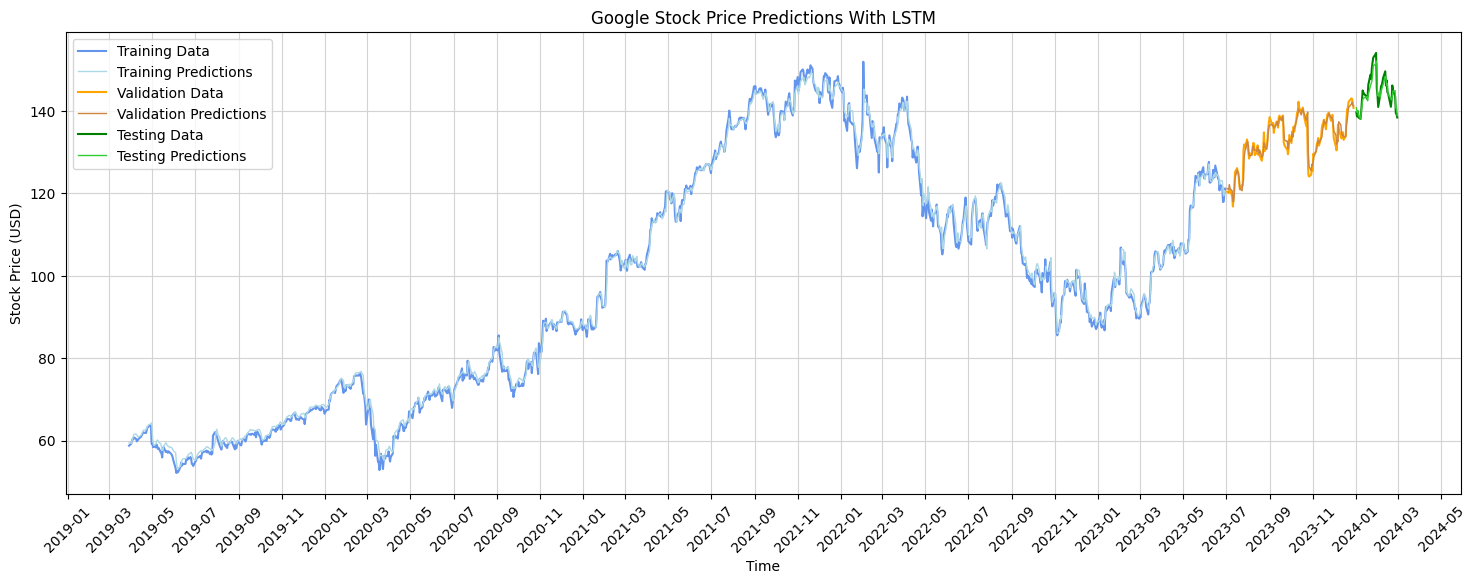

In [72]:
# Define chart colors
train_actual_color = "cornflowerblue"
validate_actual_color = "orange"
test_actual_color = "green"
train_predicted_color = "lightblue"
validate_predicted_color = "peru"
test_predicted_color = "limegreen"
# Plot actual and predicted price
plt.figure(figsize=(18,6))
plt.plot(data_train_dates[sequence_size:,], y_train_inv, label="Training Data", color=train_actual_color)
plt.plot(data_train_dates[sequence_size:,], y_train_predict_inv, label="Training Predictions", linewidth=1, color=train_predicted_color)

plt.plot(data_validate_dates, y_validate_inv, label="Validation Data", color=validate_actual_color)
plt.plot(data_validate_dates, y_validate_predict_inv, label="Validation Predictions", linewidth=1, color=validate_predicted_color)

plt.plot(data_test_dates, y_test_inv, label="Testing Data", color=test_actual_color)
plt.plot(data_test_dates, y_test_predict_inv, label="Testing Predictions", linewidth=1, color=test_predicted_color)

plt.title("Google Stock Price Predictions With LSTM")
plt.xlabel("Time")
plt.ylabel("Stock Price (USD)")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.xticks(rotation=45)
plt.legend()
plt.grid(color="lightgray")

Based on this expanded overview, the model appears to perform very well throughout the observed period, with the predicted trend tends to align closely with actual stock performance across the three training, validation, and testing periods.

To better assess the model's predictions during the validation and testing periods, let's inspect a zoomed-in version of this chart covering the most recent samples.

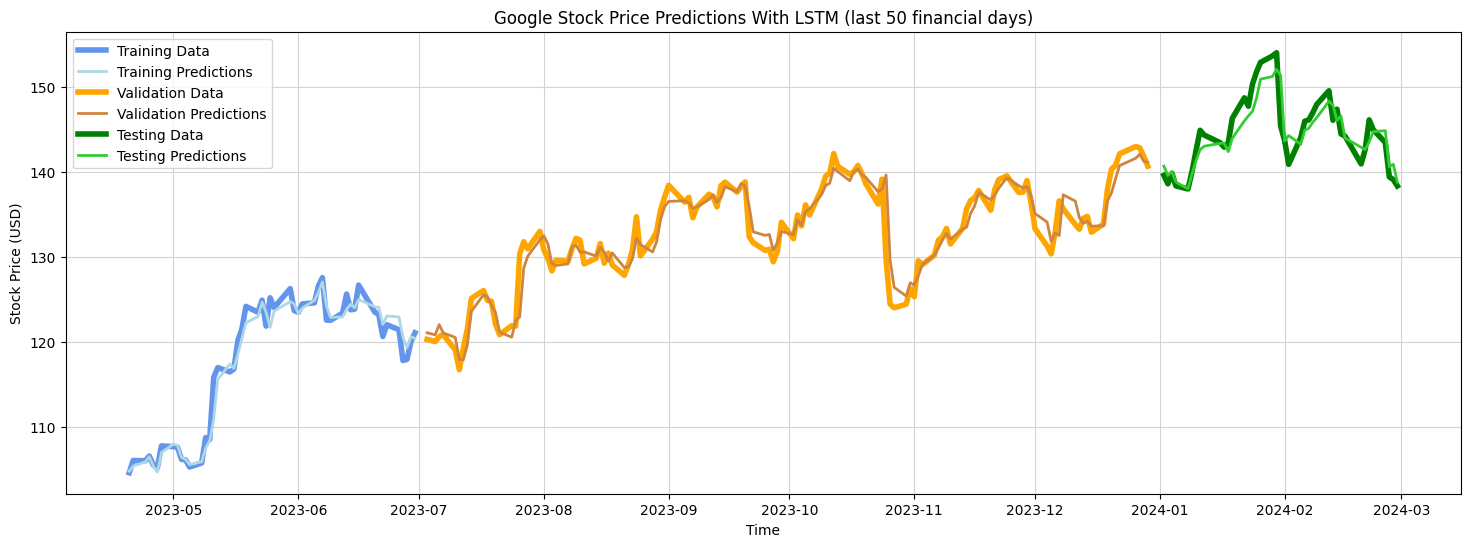

In [73]:
recent_samples = 50
plt.figure(figsize=(18,6))
plt.plot(data_train_dates[-recent_samples:,], y_train_inv[-recent_samples:,], label="Training Data", color=train_actual_color, linewidth=4)
plt.plot(data_train_dates[-recent_samples:,], y_train_predict_inv[-recent_samples:,], label="Training Predictions", linewidth=2, color=train_predicted_color)

plt.plot(data_validate_dates, y_validate_inv, label="Validation Data", color=validate_actual_color, linewidth=4)
plt.plot(data_validate_dates, y_validate_predict_inv, label="Validation Predictions", linewidth=2, color=validate_predicted_color)

plt.plot(data_test_dates, y_test_inv, label="Testing Data", color=test_actual_color, linewidth=4)
plt.plot(data_test_dates, y_test_predict_inv, label="Testing Predictions", linewidth=2, color=test_predicted_color)

plt.title("Google Stock Price Predictions With LSTM (last 50 financial days)")
plt.xlabel("Time")
plt.ylabel("Stock Price (USD)")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
# plt.xticks(rotation=45)
plt.legend()
plt.grid(color="lightgray")

This closer look underscores the great performance of our LSTM model in predicting Google's stock prices during both validation and testing periods. Indicating the ability of this model to generalize on unseen data that was not included in the training set.

Despite the exact value predictions might be slightly different from real prices, the strong performance of this model is primarily derived from its ability to consistently mirror the actual trends across almost all phases. This is the most significant takeaway of stock price predictions analysis.

Finally, with our model made and tested, calculating evaluation measures:

In [74]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model(y_true, y_pred, dataset_name=""):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"\nEvaluation Metrics - {dataset_name}")
    print(f"MAE:  {mae:.4f}")
    print(f"MSE:  {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²:   {r2:.4f}")

# Evaluate each dataset
evaluate_model(y_train_inv, y_train_predict_inv, "Training")
evaluate_model(y_validate_inv, y_validate_predict_inv, "Validation")
evaluate_model(y_test_inv, y_test_predict_inv, "Testing")


Evaluation Metrics - Training
MAE:  1.1054
MSE:  2.4105
RMSE: 1.5526
R²:   0.9971

Evaluation Metrics - Validation
MAE:  1.1804
MSE:  2.9816
RMSE: 1.7267
R²:   0.9156

Evaluation Metrics - Testing
MAE:  1.4485
MSE:  3.4398
RMSE: 1.8547
R²:   0.8085
